In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

from src.data.save_results import save_model_scores, save_model_predictions
from src.utils.data_loader import load_preprocessed_data

target_variables = [
    "temperature_2m_max",
    "apparent_temperature_min",
    "relative_humidity_2m_max",
    "wind_speed_10m_max",
    "winddirection_10m_dominant",
    "rain_sum",
    "shortwave_radiation_sum"
]

for target_variable in target_variables:
    data = load_preprocessed_data(target_variable)

    DATA = data["DATA"]
    TRAINED_DATA = data["TRAINED_DATA"]
    METHOD = data["METHOD"]

    X_train_selected = data["X_train_selected"]
    X_test_selected = data["X_test_selected"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    linear_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ])

    # Đánh giá bằng cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores_lr = cross_val_score(
        linear_pipeline, X_train_selected, y_train,
        cv=tscv, scoring='neg_root_mean_squared_error'
    )

    # Huấn luyện và đánh giá trên test set
    linear_pipeline.fit(X_train_selected, y_train)
    y_pred_lr = linear_pipeline.predict(X_test_selected)

    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    r2_lr = r2_score(y_test, y_pred_lr)

    print(f"[RESULT] Linear Regression - {target_variable}")
    print(f"[CV RMSE]: {-np.mean(cv_scores_lr):.2f} ± {np.std(cv_scores_lr):.2f}")
    print(f"[MAE]: {mae_lr:.2f}")
    print(f"[RMSE]: {rmse_lr:.2f}")
    print(f"[R2 Score]: {r2_lr:.2f}")
    
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores("LinearRegression(LR)", mae_lr, rmse_lr, r2_lr, -np.mean(cv_scores_lr), np.std(cv_scores_lr), PATH)
    save_model_predictions("LinearRegression(LR)", y_test, y_pred_lr, PATH)


[RESULT] Linear Regression - temperature_2m_max
[CV RMSE]: 0.33 ± 0.01
[MAE]: 0.25
[RMSE]: 0.34
[R2 Score]: 1.00
[RESULT] Linear Regression - apparent_temperature_min
[CV RMSE]: 1.20 ± 0.01
[MAE]: 0.97
[RMSE]: 1.25
[R2 Score]: 0.97
[RESULT] Linear Regression - relative_humidity_2m_max
[CV RMSE]: 2.40 ± 0.06
[MAE]: 1.78
[RMSE]: 2.38
[R2 Score]: 0.90
[RESULT] Linear Regression - wind_speed_10m_max
[CV RMSE]: 1.25 ± 0.03
[MAE]: 0.98
[RMSE]: 1.29
[R2 Score]: 0.91
[RESULT] Linear Regression - winddirection_10m_dominant
[CV RMSE]: 93.76 ± 2.76
[MAE]: 69.50
[RMSE]: 93.65
[R2 Score]: 0.05
[RESULT] Linear Regression - rain_sum
[CV RMSE]: 7.15 ± 0.75
[MAE]: 4.36
[RMSE]: 7.94
[R2 Score]: 0.52
[RESULT] Linear Regression - shortwave_radiation_sum
[CV RMSE]: 1.25 ± 0.04
[MAE]: 1.00
[RMSE]: 1.28
[R2 Score]: 0.96
Baseline R2: -0.0011873050421009612


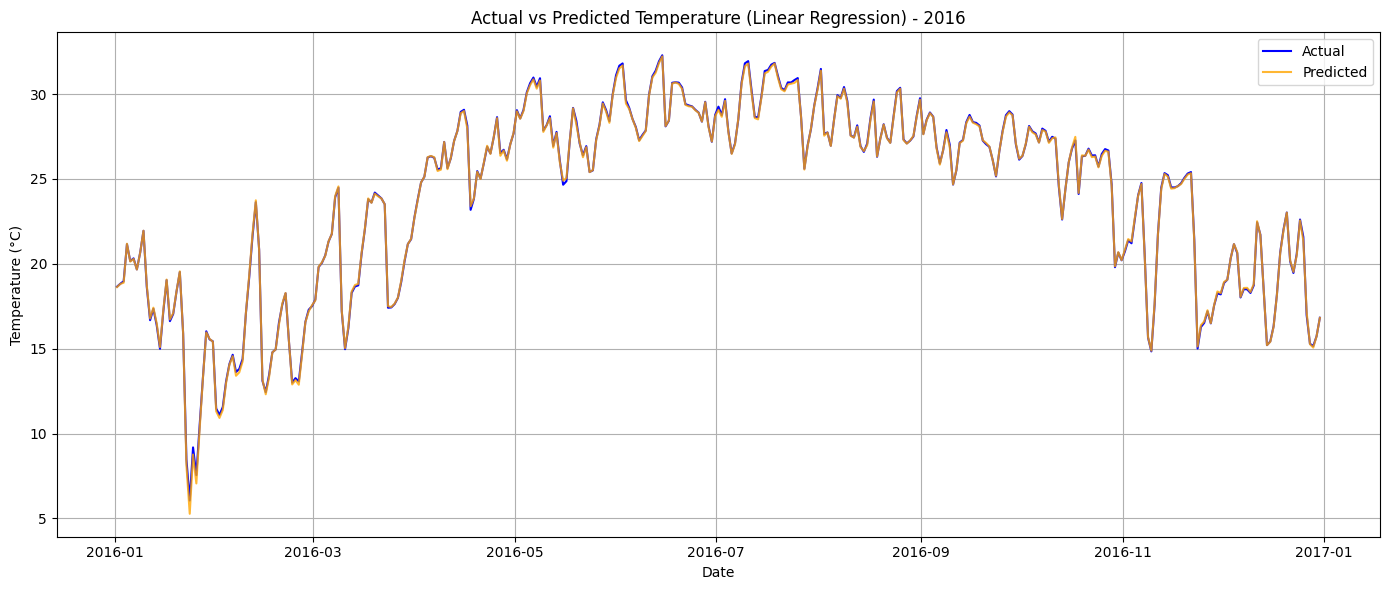

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Đọc dữ liệu và chuyển đổi cột date
test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/temperature_2m_mean/test_df.csv", parse_dates=["date"])
model_predictions = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/temperature_2m_mean/model_predictions.csv")

# Kiểm tra điều kiện: actual == temperature_2m_mean
matching = model_predictions["actual"].values == test_df["temperature_2m_mean"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions["date"] = np.where(
    matching,
    test_df["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions["date"] = pd.to_datetime(model_predictions["date"], errors="coerce")


# Lọc khoảng thời gian từ 01/01/2016 đến 31/12/2016
mask = (model_predictions["date"] >= "2016-01-01") & (model_predictions["date"] <= "2016-12-31")
subset_df = model_predictions[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["LinearRegression(LR)_pred"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Linear Regression) - 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
print("temperature_2m_mean" in X_train_selected.columns)
print("temperature_2m_mean" in X_test_selected.columns)


In [ ]:
print(X_train_selected.head())
print(X_train_selected.columns)


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (LR)")
plt.grid(True)
plt.show()


In [ ]:
df_corr = pd.concat([X_train_selected, y_train.rename("target")], axis=1)
corrs = df_corr.corr(numeric_only=True)["target"].sort_values(ascending=False)
print(corrs.head(10))


In [ ]:
from src.data.save_results import save_model_scores, save_model_predictions

PATH = DATA / "scores&predictions" / METHOD
save_model_scores("LinearRegression(LR)", mae_lr, rmse_lr, r2_lr, -np.mean(cv_scores_lr), np.std(cv_scores_lr), PATH)
save_model_predictions("LinearRegression(LR)", y_test, y_pred_lr, PATH)
